In [2]:
from sklearn.metrics.cluster import adjusted_rand_score # metric to assess the outcome of clustering algorithm
# relative to ground truth clustering [0;1]
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.datasets import make_moons, fetch_lfw_people
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import mglearn
from scipy.cluster.hierarchy import dendrogram, ward

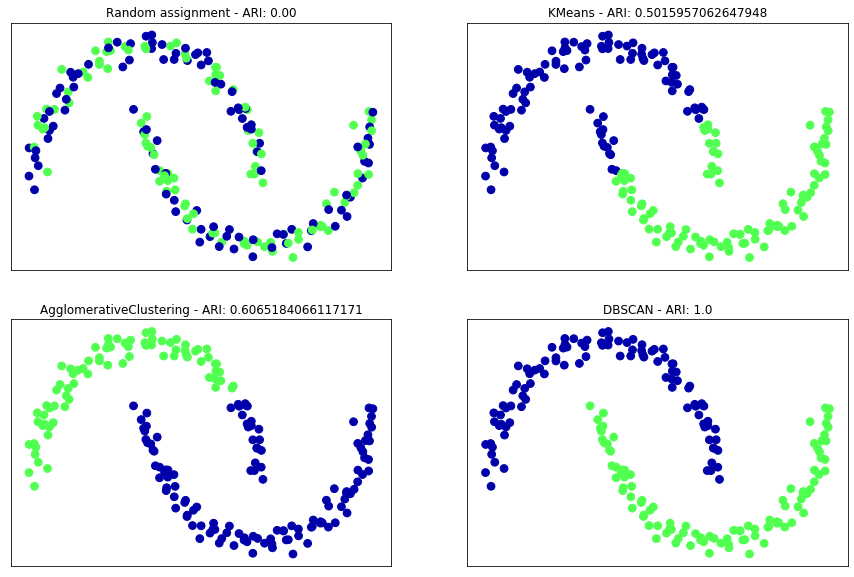

In [3]:
# Using ARI to estimate clustering algorithms

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'xticks': (), 'yticks': ()})

algorithms = [KMeans(n_clusters=2),
             AgglomerativeClustering(n_clusters=2),
             DBSCAN()]

# Random cluster assignment
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
ax1.set_title('Random assignment - ARI: {:.2f}'.format(adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip([ax2, ax3, ax4], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title('{} - ARI: {}'.format(algorithm.__class__.__name__,
                                       adjusted_rand_score(y, clusters)))

#### Evaluating clustering:
1. Supervised: adjusted rand index (ARI) (adjusted_rand_score)
2. Supervised: normalized mutual information (NMI) (normalized_mutual_info_score)
3. Without ground truth - silhouette coefficient
4. Robustness-based clustering metrics: run an algorithm after adding some noise to the data, or using different parameter settings, and compare the outcomes. 

In [4]:
# Dont use accuracy to evaluate clustering results!
# The same clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]

print('Accuracy: {:.2f}'.format(accuracy_score(clusters1, clusters2)))
print('ARI: {:.2f}'.format(adjusted_rand_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00


#### Estimation clustering results without ground truth

***Silhouette score*** :
1. computes cluster compactness
2. higher is better
3. perfect score == 1
4. fails to estimate complex shapes

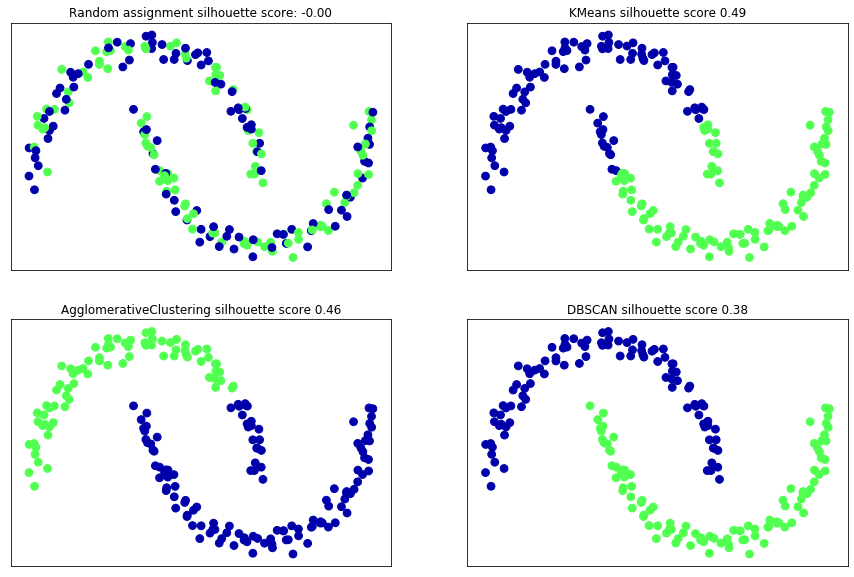

In [5]:
# Estimate clustering by Silhouette score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'xticks': (), 'yticks': ()})

# Random cluster assignment
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
ax1.set_title('Random assignment silhouette score: {:.2f}'.format(silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2),
              AgglomerativeClustering(n_clusters=2),
              DBSCAN()]
for ax, algorithm in zip([ax2, ax3, ax4], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title('{} silhouette score {:.2f}'.format(algorithm.__class__.__name__,
                                                     silhouette_score(X_scaled, clusters)))

In [6]:
# Inspecting clustering algorithms results on images

# Load dataset with images

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape    # (87, 65) 

In [7]:
# Take 50 images of each person (to make data less skewed)
 
mask = np.zeros(people.target.shape, dtype = np.bool)

for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

In [8]:
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

In [9]:
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print('Unique labels: {}'.format(np.unique(labels)))
# all samples labeled as noise

Unique labels: [-1]


In [10]:
dbscan = DBSCAN(min_samples=3) # consider group of 3 points as cluster
labels = dbscan.fit_predict(X_pca)
print('Unique labels: {}'.format(np.unique(labels)))
# still noise

Unique labels: [-1]


In [11]:
dbscan = DBSCAN(min_samples=3, eps=15) # include more points into cluster
labels = dbscan.fit_predict(X_pca)
print('Unique labels: {}'.format(np.unique(labels)))
# 1 cluster found

Unique labels: [-1  0]


In [12]:
# Count number of noise samples and samples in 1 found cluster
print('Number of point per cluster:', np.bincount(labels + 1))

Number of point per cluster: [  32 2031]


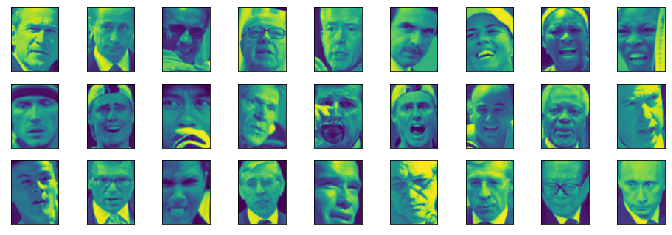

In [13]:
noise = X_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

In [14]:
# Look for clusters with different parameters settings
for eps in [1, 3, 5, 7, 9, 11, 13]:
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print('eps {}'.format(eps))
    print('Clusters present: {}'.format(np.unique(labels)))
    print('Clusters sizes {}\n'.format(np.bincount(labels + 1)))

eps 1
Clusters present: [-1]
Clusters sizes [2063]

eps 3
Clusters present: [-1]
Clusters sizes [2063]

eps 5
Clusters present: [-1]
Clusters sizes [2063]

eps 7
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Clusters sizes [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps 9
Clusters present: [-1  0  1  2]
Clusters sizes [1307  750    3    3]

eps 11
Clusters present: [-1  0]
Clusters sizes [ 413 1650]

eps 13
Clusters present: [-1  0]
Clusters sizes [ 120 1943]



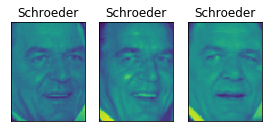

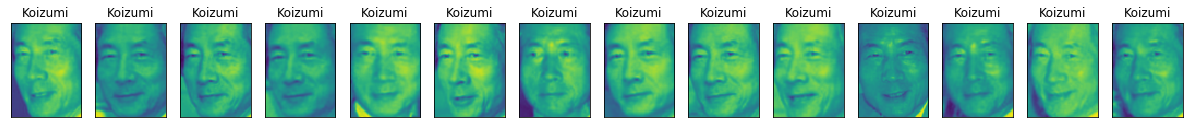

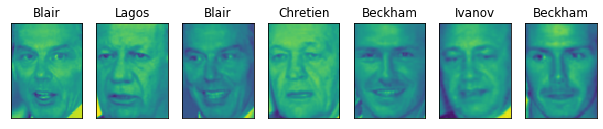

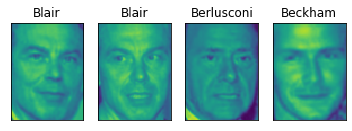

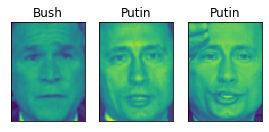

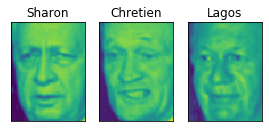

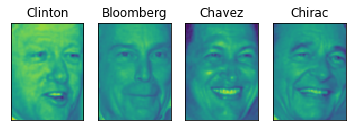

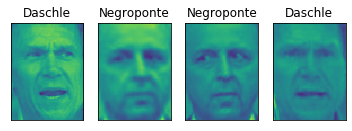

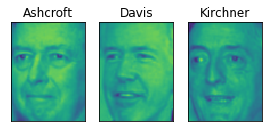

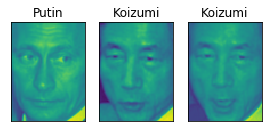

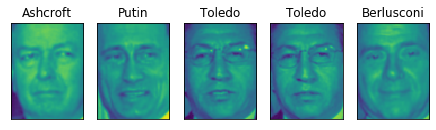

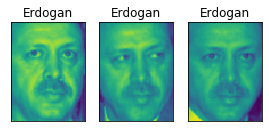

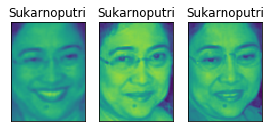

In [15]:
# Visualize partition with max.number of classes
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4), subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

In [16]:
kmeans = KMeans(n_clusters=10, random_state=42)
labels_km = kmeans.fit_predict(X_pca)
print('Clusters present: {}'.format(np.unique(labels_km)))
print('Clusters sizes {}\n'.format(np.bincount(labels_km)))

Clusters present: [0 1 2 3 4 5 6 7 8 9]
Clusters sizes [322 188 215 240 212 263 218 141 119 145]



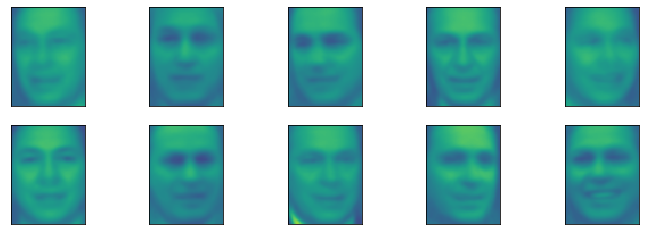

In [17]:
# Visulaize cluster centers found by kmeans
# Each center is an average of face images belonging to cluster

fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(12, 4))
for center, ax in zip(kmeans.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1)

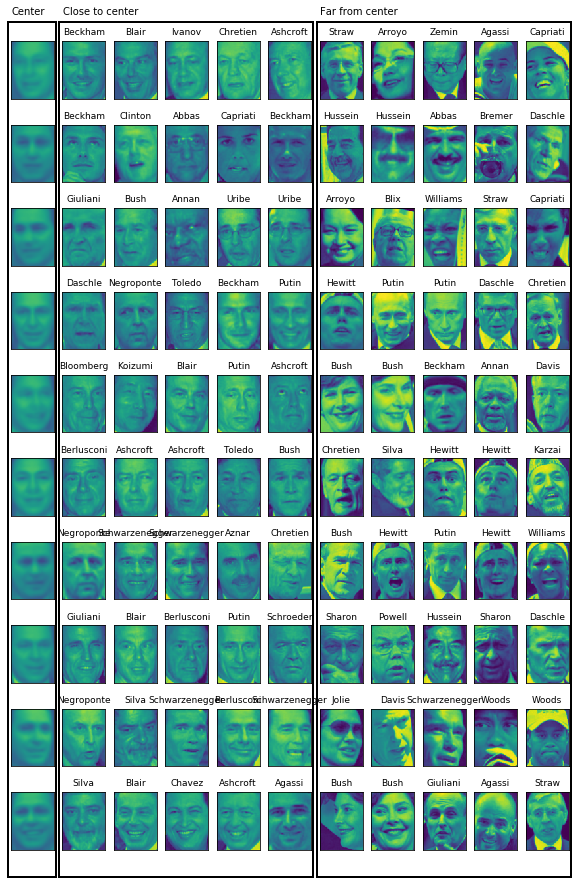

In [18]:
# Sample images for each cluster found by k-means
# Cluster centers on the left
# 5 closest points to each center
# 5 points assigned to the cluster but furthest from center 

mglearn.plots.plot_kmeans_faces(kmeans, pca, X_pca, X_people, y_people, people.target_names)

In [19]:
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print('Clusters present: {}'.format(np.unique(labels_agg)))
print('Clusters sizes {}\n'.format(np.bincount(labels_agg)))

Clusters present: [0 1 2 3 4 5 6 7 8 9]
Clusters sizes [262 586 368 295 133 194  49  86  18  72]



In [20]:
# Measure similarity between results of agglomerative and kmeans clustering
print('ARI: {}'.format(adjusted_rand_score(labels_agg, labels_km)))

ARI: 0.10070188537072355


Text(0, 0.5, 'Cluster distance')

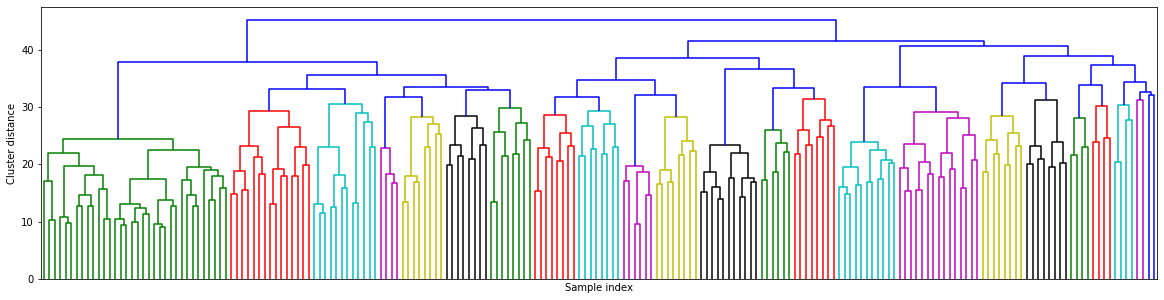

In [21]:
linkage = ward(X_pca) # contains distances between clusters
plt.figure(figsize=(20, 5))
dendrogram(linkage, p=7, truncate_mode='level', no_labels=True) # display 7 levels, don't label leaf nodes
plt.xlabel('Sample index')
plt.ylabel('Cluster distance')

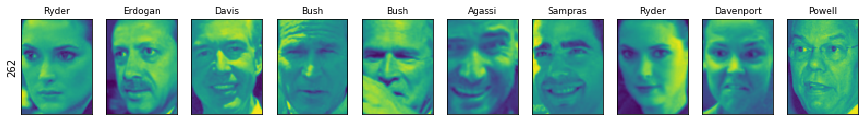

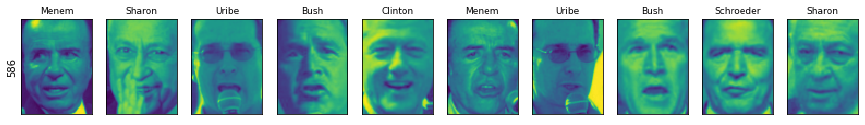

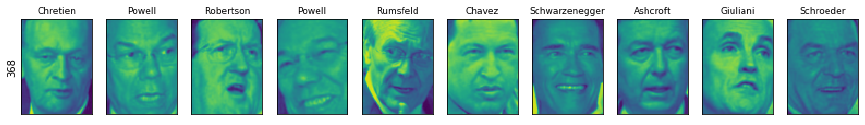

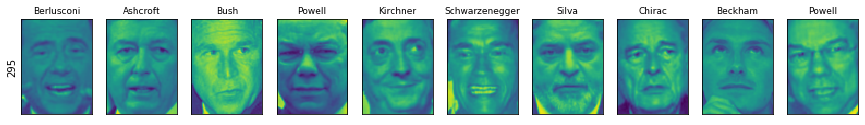

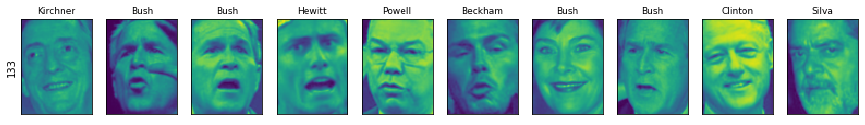

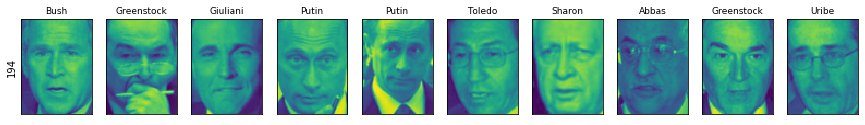

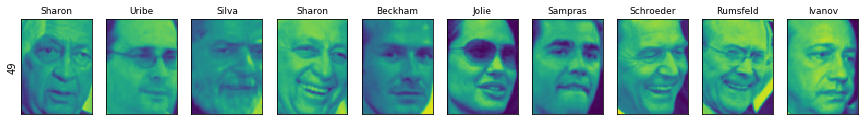

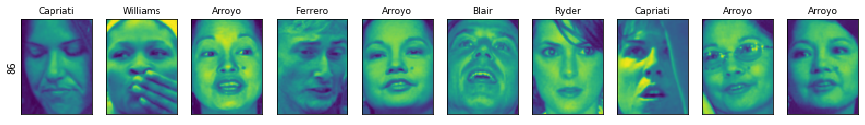

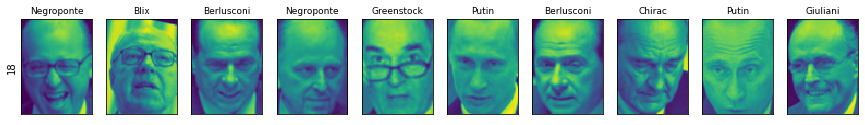

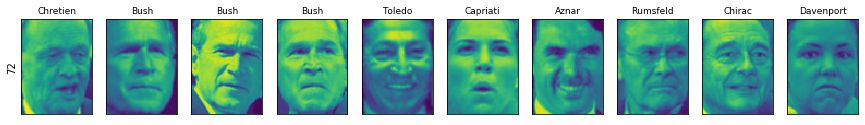

In [22]:
# Visualize first samples from each cluster

n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask)) # no.of points in each cluster
    for image, label, asdf, ax in zip(X_people[mask],
                                      y_people[mask],
                                      labels_agg[mask],
                                      axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
        fontdict={'fontsize': 9})

Clusters present: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Clusters sizes [106  29  84 139  90  23  95 113   6  41  85  75 118  49  45  77  53  13
  50   6   8  45 170   5  23  42  26  11  14  33  80  59  90   6  12  18
  30   2  77  15]



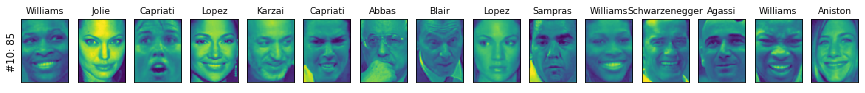

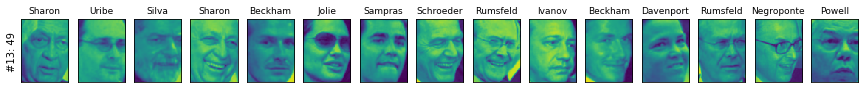

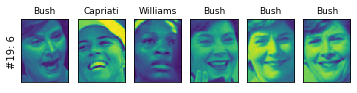

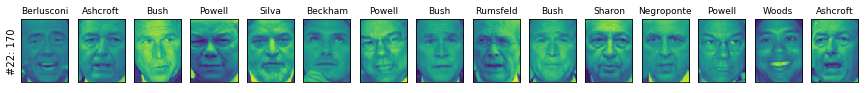

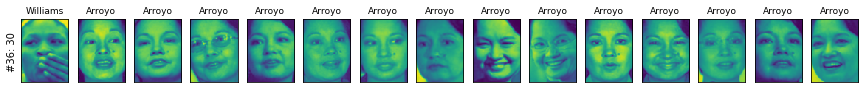

In [23]:
# Agglomerative clustering with 40 clusters, visualize only particularly

agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print('Clusters present: {}'.format(np.unique(labels_agg)))
print('Clusters sizes {}\n'.format(np.bincount(labels_agg)))

n_clusters = 40
for cluster in [10, 13, 19, 22, 36]: # hand-picked "interesting" clusters
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask],
                                      y_people[mask],
                                      labels_agg[mask],
                                      axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})
        
    for i in range(cluster_size, 15):
        axes[i].set_visible(False)